# ***Sentiment Analysis Using Transformers***

https://www.analyticsvidhya.com/blog/2022/02/sentiment-analysis-using-transformers/

In [ ]:
#Importing data

import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import Necessary libraries:

In [ ]:
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizerFast
import torch
from transformers import  DistilBertForSequenceClassification
from transformers import Trainer,TrainingArguments

Data Preparation :

In [ ]:
train  = pd.read_csv("/content/drive/MyDrive/train.tsv", sep='\t')
test = pd.read_csv("/content/drive/MyDrive/test_task2.tsv", sep='\t')

We are only interested in the label and tweet columns. We will be dropping the id column.

Dropping id as it is of no use

In [ ]:
train.drop("id", axis=1, inplace = True)
test.drop("id", axis=1, inplace = True)

Distribution of labels in the data :

In [ ]:
train = train.rename({'label ': 'label'}, axis=1) #Rename the column label

In [ ]:
train = train[~train.label.str.contains("others")]
train = train[~train.label.str.contains("disgust")]

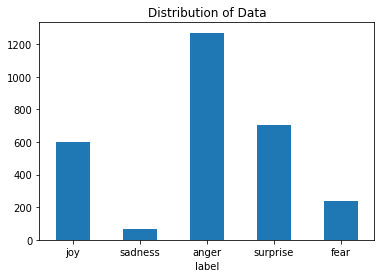

In [ ]:
ax = train.groupby('label').count().plot(kind='bar', title='Distribution of Data', legend = False)
ax.set_xticklabels(['joy','sadness','anger','surprise','fear'], rotation = 0)
text,sentiment = list(train['tweet']), list(train['label'])

In [ ]:
train.dtypes

tweet    object
label    object
dtype: object

In [ ]:
label_map = {
    'joy ': 0,
    'sadness ': 1,
    'anger ': 2,
    'surprise ': 3,
    'fear ': 4,
}

train['label'] = train['label'].map(label_map)
train

,tweet,label
0,El Atlético resignado a perder HASHTAG 😔 http...,1
1,Leer proporciona una mejor visión del mundo 🤓 ...,0
2,Amo a Arya Stark por encima de todas las cosas...,0
4,Solo siento que hayamos perdido 24 escaños de ...,1
5,Solo con ver con la intensidad que agitan las ...,0
...,...,...
5879,IMPOSIBLE DE VER: Melisandre podría estar ya e...,3
5882,¿Sabías que de las dos coronaciones que se cel...,3
5883,Mientras reflexionamos sobre lo duro que es es...,2
5884,La fachada de la catedral de Notre Dame fue “s...,1


We will need to convert the tweet and labels column in the form of a list so that we can input them to the tokenizer that we will see the further steps

In [ ]:
labels = train['label'].tolist()
tweets = train['tweet'].tolist()

## *Tokenization and Encoding of data*

The tokenizer that we will be using is DistillBert tokenizer fast. DistilBertTokenizerFast is identical to BertTokenizerFast and runs end-to-end tokenization: punctuation splitting and wordpiece

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Padding and truncation of data

In [ ]:
inputs = tokenizer (tweets, padding="max_length", truncation=True)

Now since we are using PyTorch to implement this we will convert our data to tensors. So for converting the data into tensor we will be using the twitterDataset class that is implemented below

In [ ]:
import torch

class twitterDataset(torch.utils.data.Dataset):
  def __init__(self, encodings,labels): 
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item= {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels']= torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = twitterDataset(inputs,labels)

In [ ]:
print(train_dataset.__getitem__(2))

{'input_ids': tensor([  101,  2572,  2080,  1037, 26140,  9762, 18499,  4372,  6895,  2863,
         2139, 28681,  3022,  5869,  2522, 20939,   100,  1001,  2208, 15794,
         8093, 21821, 23325, 15900,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5 )

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [ ]:
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset= train_dataset
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2884
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 362


Step,Training Loss
10,1.669900
20,1.621500
30,1.536000
40,1.461900
50,1.323100
60,1.385200
70,1.279400
80,1.269300
90,1.236000
100,1.281400




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=362, training_loss=1.0948122423656739, metrics={'train_runtime': 16688.3698, 'train_samples_per_second': 0.346, 'train_steps_per_second': 0.022, 'total_flos': 764112833863680.0, 'train_loss': 1.0948122423656739, 'epoch': 2.0})

In [ ]:
def to_check_results(test_encoding):
  input_ids = torch.tensor(test_encoding["input_ids"])
  attention_mask = torch.tensor(test_encoding["attention_mask"])
  with torch.no_grad():
    outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
  y = np.argmax(outputs[0].numpy())

  return y

l2 list contains the output sentiment of all the tweets in the test data.

In [ ]:
l2 =[]

for i in test['tweet']:
  test_encoding1 = tokenizer(i, truncation = True, padding= True)
  input_ids = torch.tensor(test_encoding["input_ids"])
  attention_mask = torch.tensor(test_encoding["attention_mask"])
  op = to_check_results(test_encoding1)
  l2.append(op)


In [ ]:
l2


[1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 3,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 3,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
